In [51]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import gls
import math

In [52]:
X_train = pd.read_csv('../data/curated/model/X_train.csv')
y_train = pd.read_csv('../data/curated/model/y_train.csv')
X_val = pd.read_csv('../data/curated/model/X_val.csv')
y_val = pd.read_csv('../data/curated/model/y_val.csv')
X_test = pd.read_csv('../data/curated/model/X_test.csv')
y_test = pd.read_csv('../data/curated/model/y_test.csv')

In [53]:
X_train

Unnamed: 0  PULocationID  total_with_tip  trip_distance  fare_amount  \
0               0             1        1.084904       3.372621     1.363832   
1               1             1        3.201487      -2.551986     2.712761   
2               2             1        1.123441       2.897021     1.000658   
3               3             1       -1.449377       0.260843    -1.178380   
4               4             1       -0.193871       1.877880     0.455899   
...           ...           ...             ...            ...          ...   
18364       18364           163        0.721619      -0.528510    -0.446066   
18365       18365           163        0.643079      -0.554441    -0.445522   
18366       18366           163        0.196409      -0.468254    -0.591596   
18367       18367           163        0.092336      -0.367722    -0.680809   
18368       18368           163        0.548180      -0.557806    -0.550526   

       tip_amount      TEMP      DEWP      WDSP     MXSPD      GUST       MAX  \
0        0.931607  0.798488  0.676687  1.331435  2.467679 -0.442229  0.881842   
1        1.665827  1.331756  0.560247  0.685311 -0.368222 -0.479152  1.316808   
2        0.974456  1.235887  0.653399  0.513011  1.580107 -0.455680  1.208066   
3        0.206265  1.122043  1.289936 -0.391562  0.281221 -0.468867  1.208066   
4        0.417579  1.259854 -0.689540 -0.434637 -0.563054 -0.495241  1.534291   
...           ...       ...       ...       ...       ...       ...       ...   
18364    0.974456 -0.705447 -0.006426 -1.209986 -1.039312  2.110242 -0.749279   
18365    0.943030 -0.507719  0.436045 -0.736162 -0.822832 -0.495241 -0.423055   
18366    0.713271 -0.124245  0.583535 -0.994611 -0.151741 -0.471504 -0.314314   
18367    0.709430 -0.507719  0.257504  0.383786  1.147145 -0.455680 -0.640538   
18368    0.897487 -0.927143 -0.441135  2.149859  0.735831 -0.463328 -1.184245   

            MIN  
0      0.814166  
1      1.355327  
2      1.138863  
3      1.138863  
4      0.814166  
...         ...  
18364 -0.484620  
18365 -0.268156  
18366  0.164773  
18367 -0.376388  
18368 -0.809317  

[18369 rows x 13 columns]

In [54]:
# Predictors
X_train = X_train.iloc[:, 1:]
X_val = X_val.iloc[:, 1:]
X_test = X_test.iloc[:, 1:]

# Responses
y_train = y_train.iloc[:, 1:]
y_val = y_val.iloc[:, 1:]
y_test = y_test.iloc[:, 1:]


In [55]:
# combine predictors and responses into dfs for ease of model handling
# and reset indices to align data and ensure proper merging
train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
val = pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)
test = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

In [56]:
print(train.columns)

filtered_train = train[train['earnings_rate'] > 0.00]
# 'inv_ir' as the inverse of 'earnings_rate'
filtered_train['inv_ir'] = 1 / filtered_train['earnings_rate']

train = filtered_train


Index(['PULocationID', 'total_with_tip', 'trip_distance', 'fare_amount',
       'tip_amount', 'TEMP', 'DEWP', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN',
       'earnings_rate'],
      dtype='object')


In [57]:
filtered_train = train.query('earnings_rate < 10')
filtered_train.count()


PULocationID      18005
total_with_tip    18005
trip_distance     18005
fare_amount       18005
tip_amount        18005
TEMP              18005
DEWP              18005
WDSP              18005
MXSPD             18005
GUST              18005
MAX               18005
MIN               18005
earnings_rate     18005
inv_ir            18005
dtype: int64

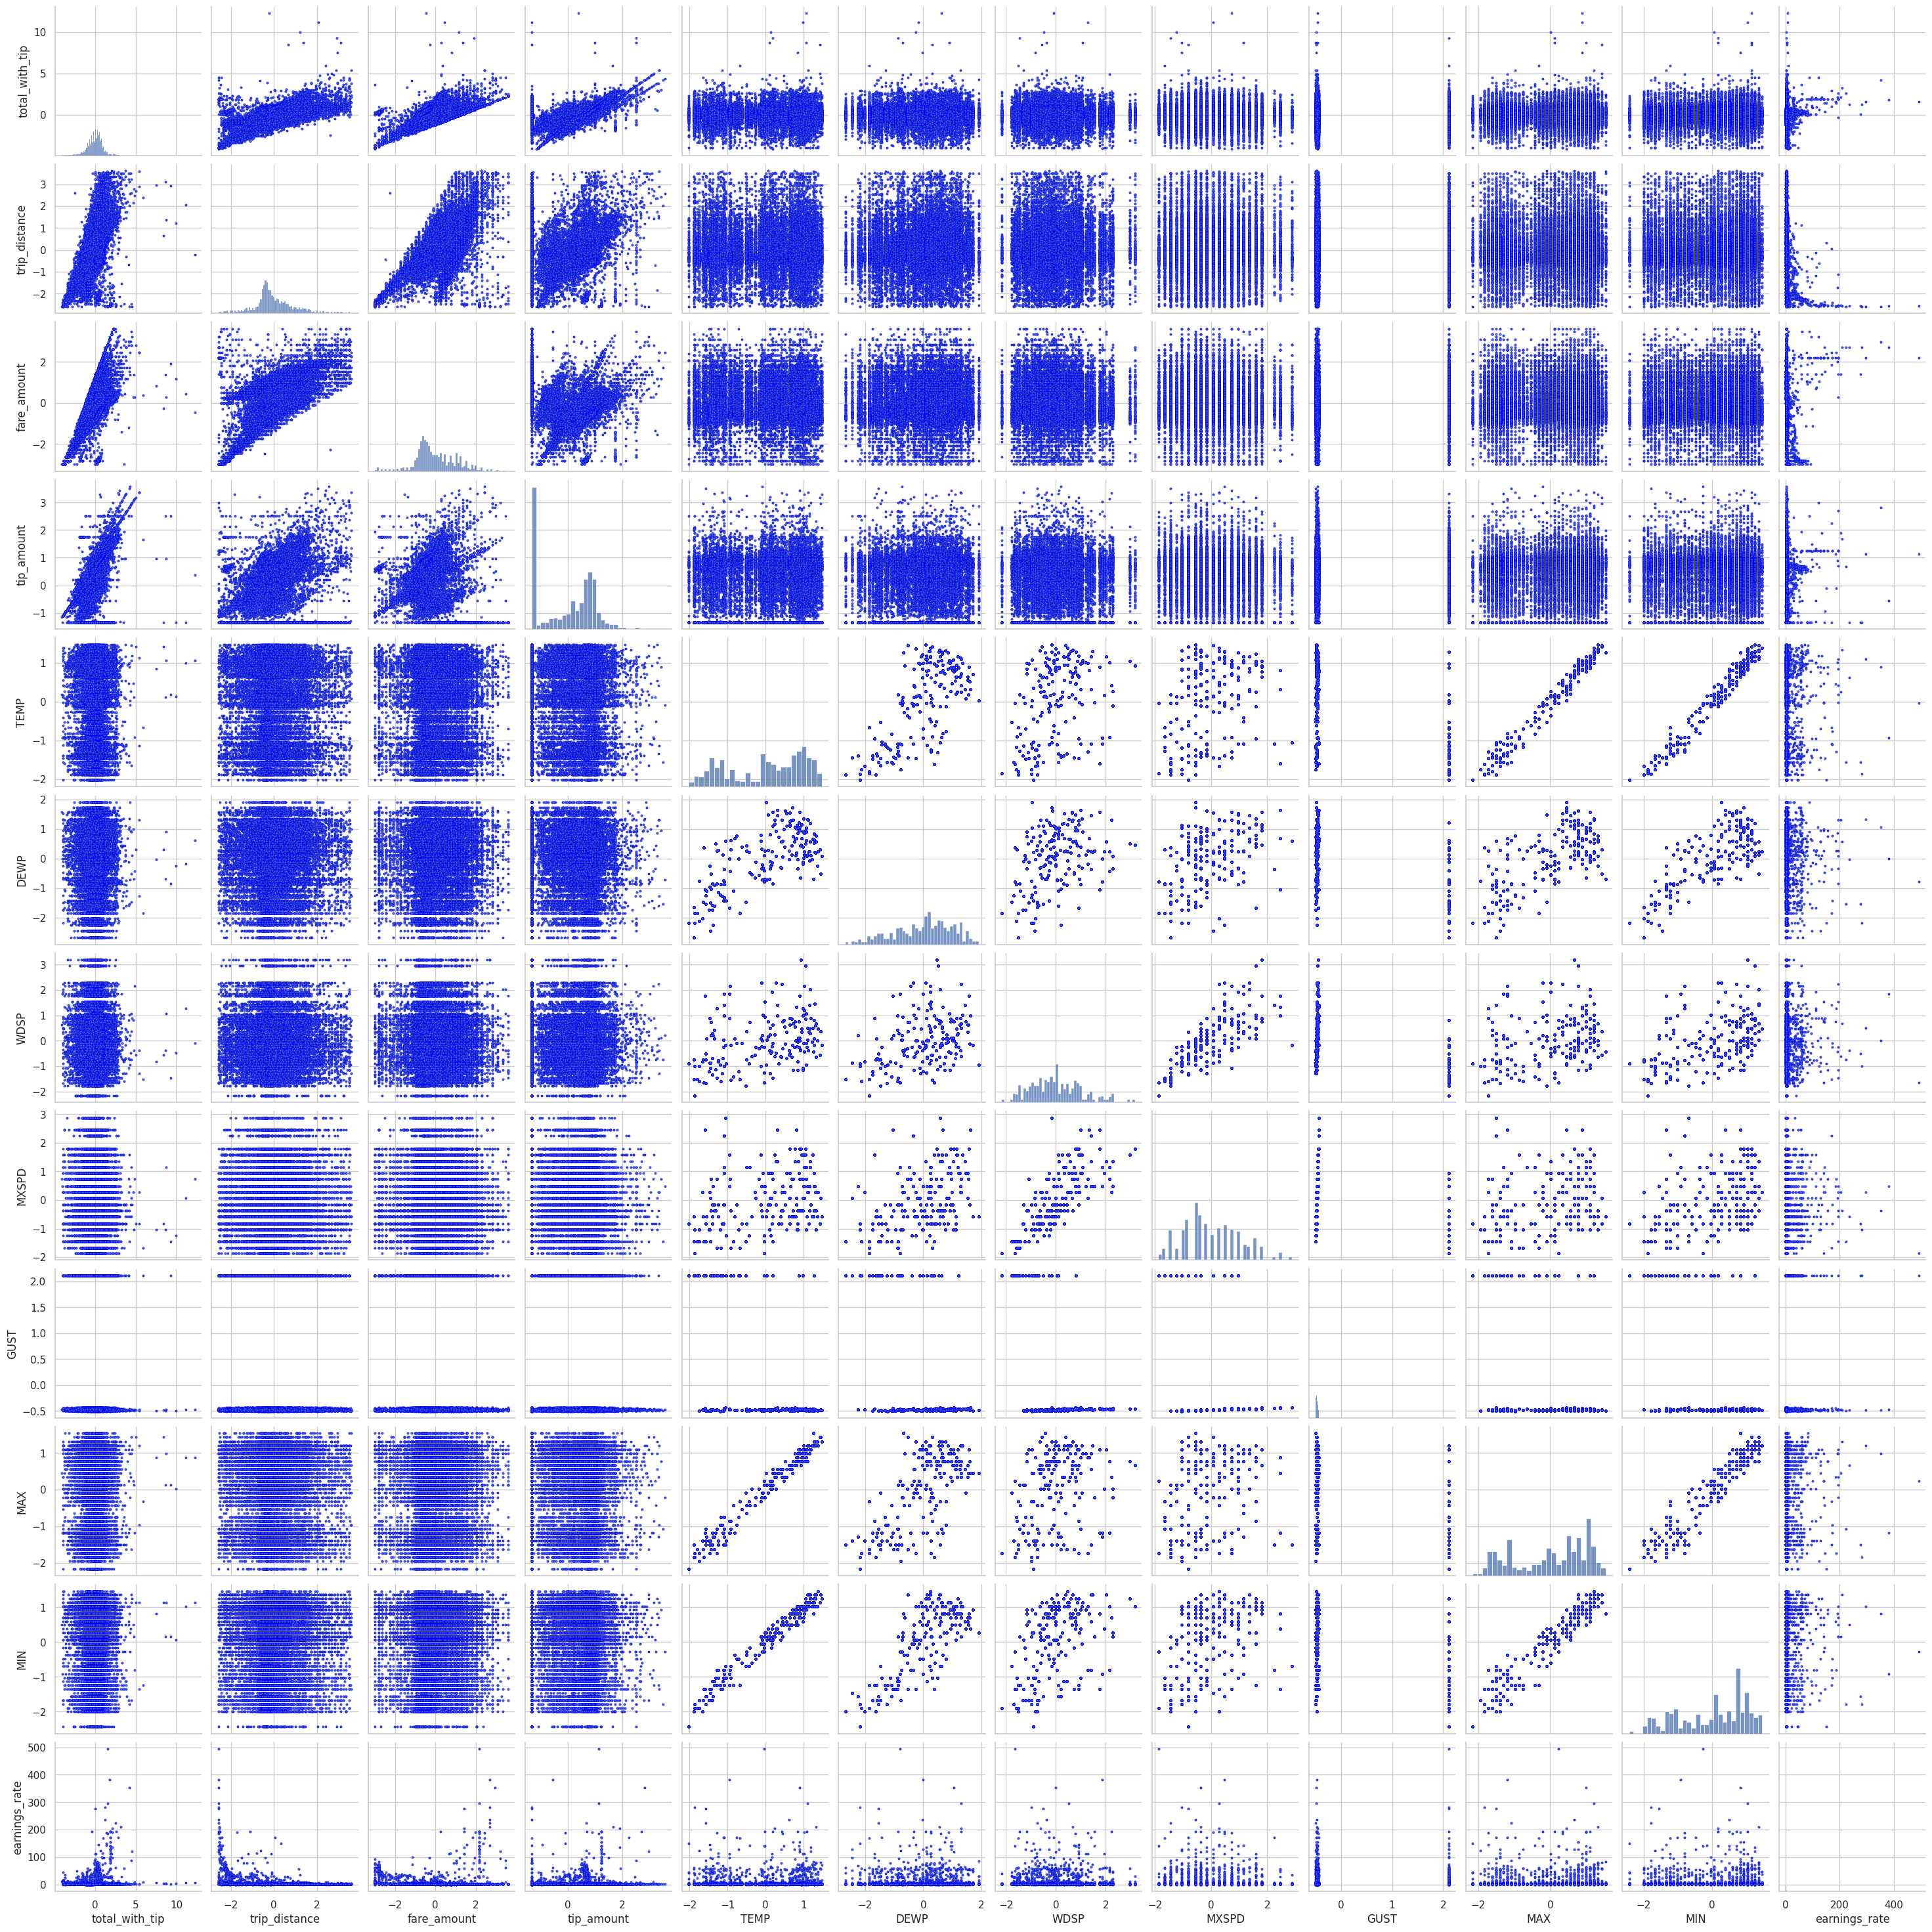

In [58]:
import seaborn as sns


# use features after feature selection with F-test
features = ['total_with_tip', 'trip_distance', 'fare_amount', 'tip_amount', 
            'TEMP', 'DEWP', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'earnings_rate']

sns.set(style='whitegrid', color_codes=True)

g = sns.pairplot(train[features], plot_kws={'s': 5, 'edgecolor': 'blue', 'linewidth': 0.5})


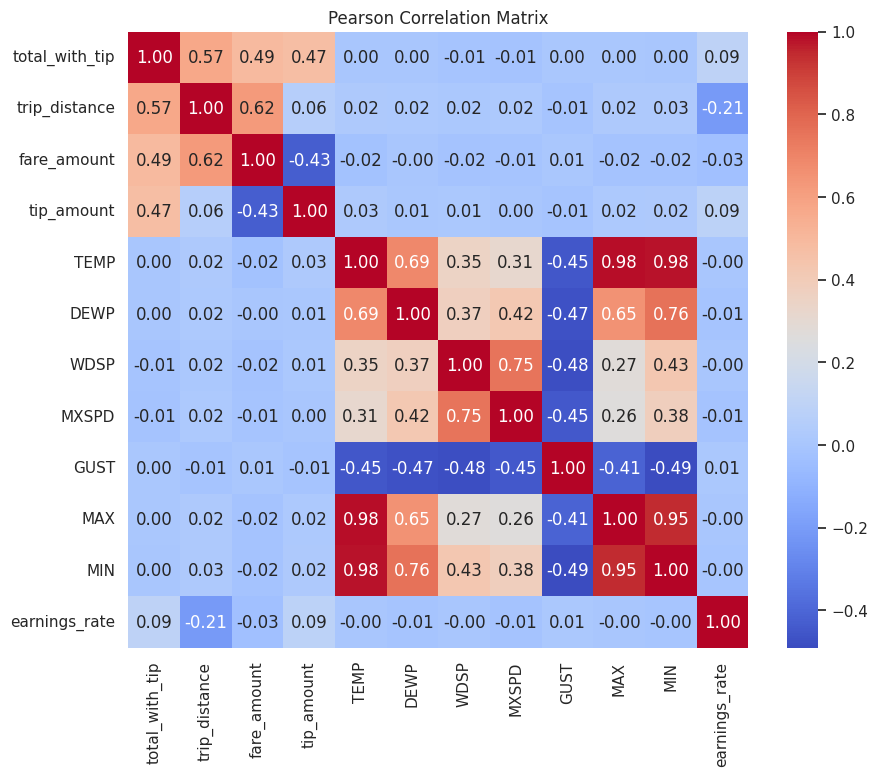

In [59]:
corr_matrix = train[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Pearson Correlation Matrix')

plt.show()

The graph shows heteroskedasticity 

In [60]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# formula for the model with all features
formula = (
    "earnings_rate ~ total_with_tip + trip_distance + fare_amount + tip_amount + "
    "TEMP + DEWP + WDSP + MXSPD + GUST + MAX + MIN"
)


ols_model = ols(formula, data=train).fit()

# perform GLS fitting to account for heteroskedasticity
# and use the residuals from the OLS model to estimate the variance
gls_model = sm.GLS.from_formula(formula, data=train, sigma=ols_model.resid**2).fit()

print(gls_model.summary())

                            GLS Regression Results                            
Dep. Variable:          earnings_rate   R-squared:                       0.998
Model:                            GLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 8.845e+05
Date:                Fri, 23 Aug 2024   Prob (F-statistic):               0.00
Time:                        01:26:26   Log-Likelihood:                -38376.
No. Observations:               18369   AIC:                         7.678e+04
Df Residuals:                   18357   BIC:                         7.687e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.8791      0.001   2548.

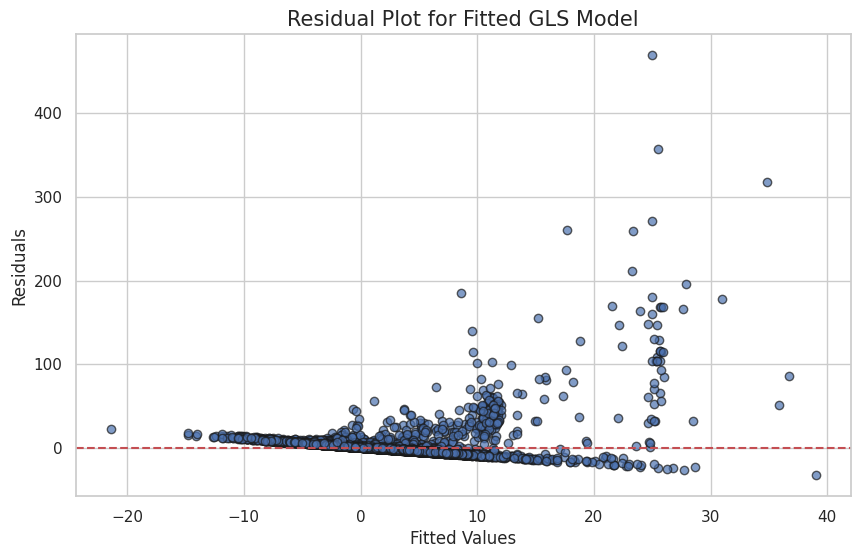

In [61]:
fit1 = gls(
    formula="earnings_rate ~ total_with_tip + trip_distance + fare_amount + tip_amount + "
    "TEMP + DEWP + WDSP + MXSPD + GUST + MAX + MIN",
    data=train
).fit()

fitted_values = fit1.fittedvalues
residuals = train['earnings_rate'] - fitted_values

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.7, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')

plt.title('Residual Plot for Fitted GLS Model', fontsize=15)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.show()

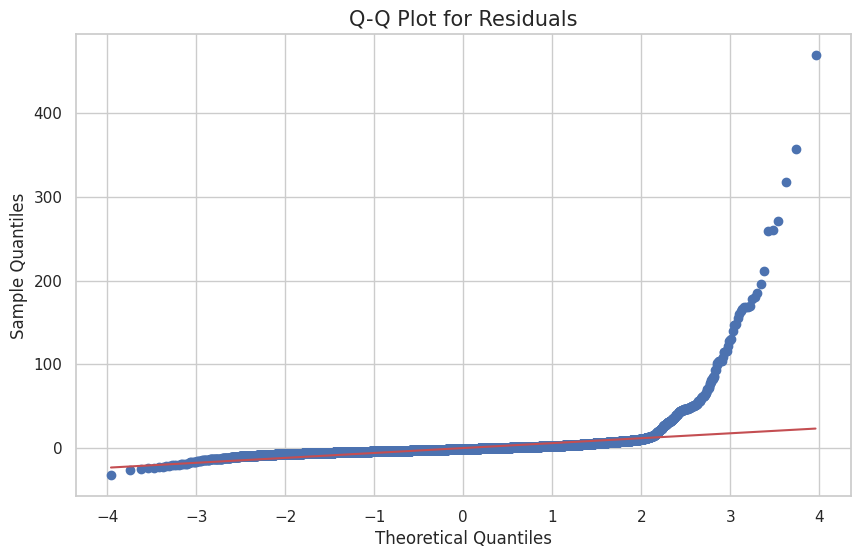

In [62]:
import scipy.stats as stats

plt.figure(figsize=(10, 6))

train_pred = fit1.fittedvalues
train_true = train['earnings_rate']
residual = np.subtract(train_true, train_pred)
stats.probplot(residual, dist="norm", plot=plt)

plt.title('Q-Q Plot for Residuals', fontsize=15)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.show()

In [63]:
print(fit1.summary())

                            GLS Regression Results                            
Dep. Variable:          earnings_rate   R-squared:                       0.118
Model:                            GLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     224.2
Date:                Fri, 23 Aug 2024   Prob (F-statistic):               0.00
Time:                        01:26:26   Log-Likelihood:                -69433.
No. Observations:               18369   AIC:                         1.389e+05
Df Residuals:                   18357   BIC:                         1.390e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.8940      0.078     36.

/home/ambrosehe/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ambrosehe/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ambrosehe/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ambrosehe/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


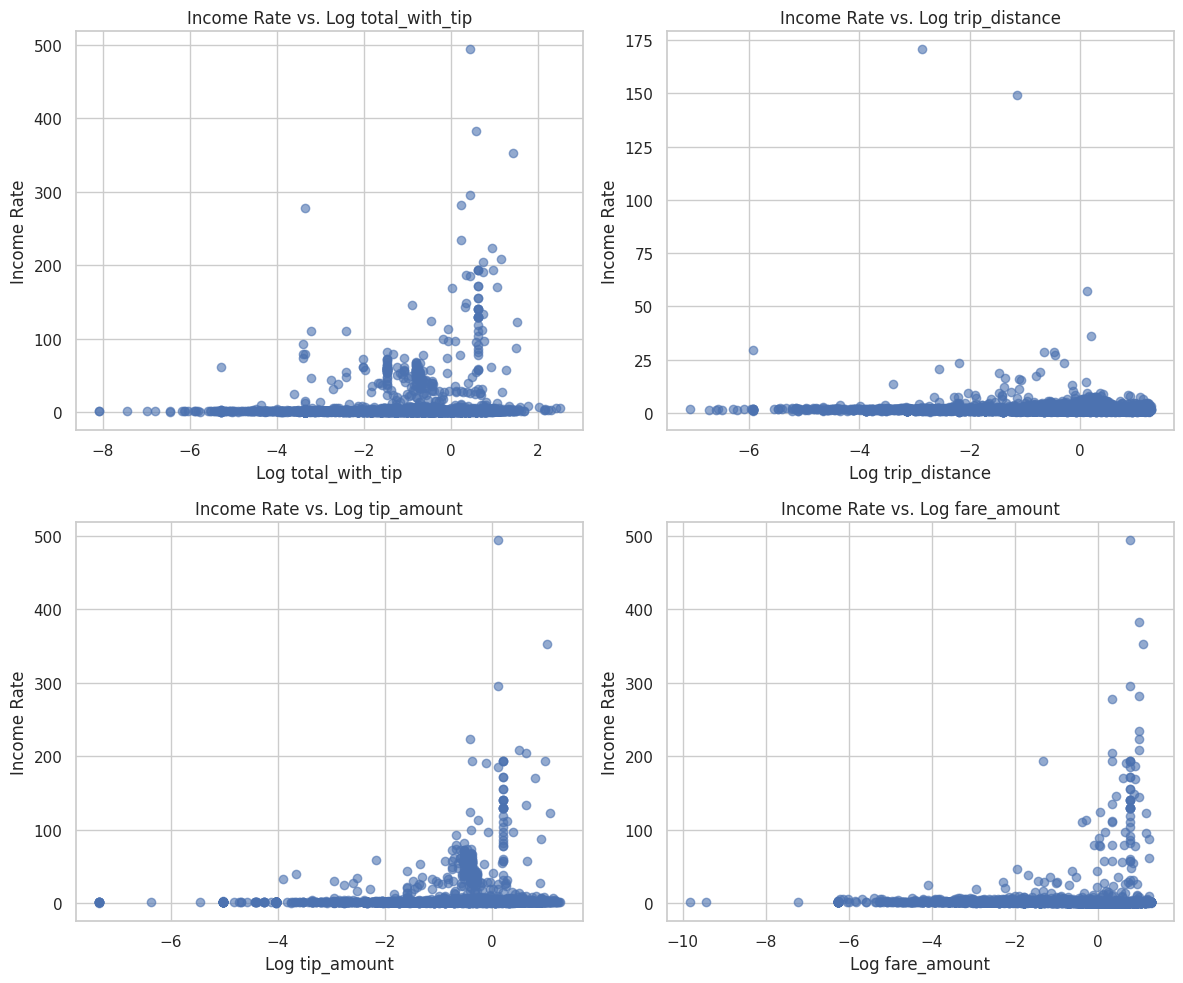

In [64]:
features = {
    'total_with_tip': 'log_twt',
    'trip_distance': 'log_td',
    'tip_amount': 'log_ta',
    'fare_amount': 'log_fa'
}

plt.figure(figsize=(12, 10))

for i, (feature, log_feature) in enumerate(features.items(), start=1):
    # apply log transformation
    train[log_feature] = np.log(train[feature])
    
    plt.subplot(2, 2, i)
    plt.scatter(train[log_feature], train['earnings_rate'], alpha=0.6)
    plt.title(f'Income Rate vs. Log {feature}')
    plt.xlabel(f'Log {feature}')
    plt.ylabel('Income Rate')

plt.tight_layout()
plt.show()

In [65]:
fit2 = sm.formula.ols(
    formula="earnings_rate ~ log_twt + log_td + log_fa + log_ta + TEMP + DEWP + WDSP + MXSPD + GUST + MAX + MIN",
    data=train
).fit()

print(fit2.summary())


                            OLS Regression Results                            
Dep. Variable:          earnings_rate   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.972
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           0.000631
Time:                        01:26:27   Log-Likelihood:                -6104.8
No. Observations:                2153   AIC:                         1.223e+04
Df Residuals:                    2141   BIC:                         1.230e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2273      0.132     16.870      0.0

choosing a model with a higher R_squared is often advantageous because it explains a greater proportion of the variance in the dependent variable, therefore we will use fit1

In [66]:
features_1 = ['total_with_tip', 'trip_distance', 'fare_amount', 
              'tip_amount', 'TEMP', 'DEWP', 'WDSP', 'MXSPD', 'GUST', 
              'MAX', 'MIN',]

In [67]:
# predictions
train_predictions1 = fit1.predict(train.loc[:, features_1])
val_predictions1 = fit1.predict(val.loc[:, features_1])
test_predictions1 = fit1.predict(test.loc[:, features_1])


In [68]:
from sklearn.metrics import r2_score

r2_train = r2_score(train['earnings_rate'], train_predictions1)
r2_val = r2_score(val['earnings_rate'], val_predictions1)
r2_test = r2_score(test['earnings_rate'], test_predictions1)

print(f"{'Dataset':<15} {'R^2 Score':<10}")
print(f"{'-' * 25}")
print(f"{'Training Set':<15} {r2_train:.3f}")
print(f"{'Validation Set':<15} {r2_val:.3f}")
print(f"{'Test Set':<15} {r2_test:.3f}")


Dataset         R^2 Score 
-------------------------
Training Set    0.118
Validation Set  -192.161
Test Set        -429.852


In [69]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(train['earnings_rate'], train_predictions1)
rmse_train = np.sqrt(mse_train)

mse_val = mean_squared_error(val['earnings_rate'], val_predictions1)
rmse_val = np.sqrt(mse_val)

mse_test = mean_squared_error(test['earnings_rate'], test_predictions1)
rmse_test = np.sqrt(mse_test)

print(f"{'Dataset':<15} {'RMSE':<10}")
print(f"{'-' * 25}")
print(f"{'Training Set':<15} {rmse_train:.3f}")
print(f"{'Validation Set':<15} {rmse_val:.3f}")
print(f"{'Test Set':<15} {rmse_test:.3f}")


Dataset         RMSE      
-------------------------
Training Set    10.601
Validation Set  132.750
Test Set        133.771


In [ ]:
test_predictions.to_csv('../data/curated/LinReg_prediction.csv')